# Setup

Here I will go over setting up our interfaces and emulators from a raw spectral library to prepare us for fitting some data in further examples.

### Getting the Grid

To begin, we need a spectral model library that we will use for our fitting. One common example are the PHOENIX models, most recently computed by T.O. Husser. We provide many interfaces directly with different libraries, which can be viewed in [Raw Grid Interfaces](../api/grid_tools.rst#raw-grid-interfaces).

As a convenience, we provide a helper to download PHOENIX models from the Goettingen servers. Note this will skip any files already on disk.

In [1]:
import itertools
import numpy as np

from Starfish.grid_tools import download_PHOENIX_models

ranges = [[5700, 8600], [4.0, 6.0], [-0.5, 0.5]]  # T, logg, Z

download_PHOENIX_models(path="PHOENIX", ranges=ranges)

lte08600-6.00+0.5.PHOENIX-ACES-AGSS-COND-2011-HiRes.fits: 100%|██████████| 330/330 [00:00<00:00, 1069.89it/s]


Now that we have the files downloaded, let's set up a grid interface

In [2]:
from Starfish.grid_tools import PHOENIXGridInterfaceNoAlpha

grid = PHOENIXGridInterfaceNoAlpha(path="PHOENIX")

From here, we will want to set up our HDF5 interface that will allow us to go on to using the spectral emulator, but first we need to determine our model subset and instrument.

### Setting up the HDF5 Interface

We set up an HDF5 interface in order to allow much quicker reading and writing than compared to loading FITS files over and over again. In addition, when considering the application to our likelihood methods, we know that for a given dataset, any effects characteristic of the instrument can be pre-applied to our models, saving on computation time during the maximum likelihood estimation.

Looking towards our fitting examples, we know we will try fitting some data from the TRES spectrograph. We provide many popular spectrographs in our grid tools, including TRES.

Let’s also say that, for a given dataset (in our future examples we use WASP 14 so let’s consider that), we want to only use a reasonable subset of our original model grid. WASP 14 is currently labeled as an F5V star, so let’s create a subset around that classification.

In [3]:
from Starfish.grid_tools.instruments import SPEX
from Starfish.grid_tools import HDF5Creator

creator = HDF5Creator(grid, "F_SPEX_grid.hdf5", instrument=SPEX(), ranges=ranges)
creator.process_grid()

Processing [8.6e+03 6.0e+00 5.0e-01]: 100%|██████████| 330/330 [06:54<00:00,  1.25s/it]   


### Setting up the Spectral Emulator

Once we have our pre-processed grid, we can make our spectral emulator and train its Gaussian process hyperparameters.

In [4]:
from Starfish.grid_tools import HDF5Interface
from Starfish.emulator import Emulator

grid = HDF5Interface("F_SPEX_grid.hdf5")
emu = Emulator.from_grid(grid)
emu

Emulator
--------
Trained: False
lambda_xi: 1.000
Variances:
	10000.00
	10000.00
	10000.00
	10000.00
Lengthscales:
	[ 600.00  1.50  1.50 ]
	[ 600.00  1.50  1.50 ]
	[ 600.00  1.50  1.50 ]
	[ 600.00  1.50  1.50 ]
Log Likelihood: -1227.19

In [5]:
%time emu.train(options=dict(maxiter=1e5))
emu

CPU times: user 13min 4s, sys: 33.6 s, total: 13min 37s
Wall time: 5min 7s


Emulator
--------
Trained: True
lambda_xi: 1.003
Variances:
	99271.73
	551.89
	250.41
	818.95
Lengthscales:
	[ 2079.81  14.25  1.77 ]
	[ 1522.14  1.04  2.64 ]
	[ 1462.24  1.84  1.00 ]
	[ 1165.86  1.29  2.30 ]
Log Likelihood: -695.12

<div class="alert alert-info">
  
**Note:** If the emulator does not optimize the first time you use ``train``, just run it again. You can also tweak the arguments passed to ``scipy.optimize.minimize`` by passing them as keyword arguments to the call.
    
</div>

<div class="alert alert-warning">

**Warning:** Training the emulator will take on the order of minutes to complete. The more eigenspectra that are used as well as the resolution of the spectrograph will mainly dominate this runtime.

</div>

We can do a sanity check on the optimization by looking at slice of the emulator's parameter space and the corresponding Gaussian process fit. We should see a smooth line connecting all the parameter values with some uncertainty that grows with large gaps or turbulent weights.

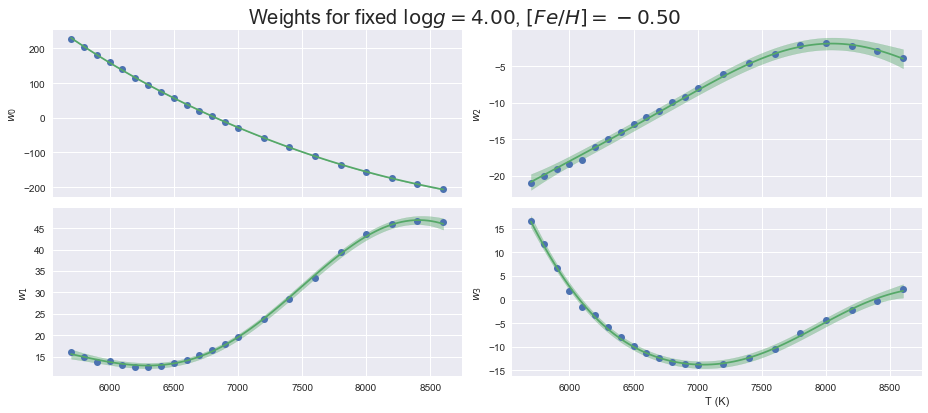

In [6]:
%matplotlib inline
from Starfish.emulator.plotting import plot_emulator

plot_emulator(emu)

If we are satisfied, let's save this emulator and move on to fitting some data.

In [7]:
emu.save("F_SPEX_emu.hdf5")